In [ ]:
import os
import pandas as pd
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import timm  # For loading pre-trained transformers
import torch.optim as optim

# Dataset loading
csv_file = "/home/kirtimaan/Projects/archive/Glaucoma.csv"
image_dir = "/home/kirtimaan/Projects/archive/ORIGA/ORIGA/Images"

df = pd.read_csv(csv_file)
df['Glaucoma'] = df['Glaucoma'].astype(int)

# Custom dataset class
class GlaucomaDataset(Dataset):
    def __init__(self, dataframe, img_dir, transform=None):
        self.dataframe = dataframe
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_name = os.path.join(self.img_dir, self.dataframe.iloc[idx, 0])
        image = Image.open(img_name).convert("RGB")
        label = self.dataframe.iloc[idx, 4]  # Glaucoma label
        if self.transform:
            image = self.transform(image)
        return image, label

# Transform for preprocessing
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Split the dataset into train and test sets
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['Glaucoma'])

train_dataset = GlaucomaDataset(train_df, image_dir, transform)
test_dataset = GlaucomaDataset(test_df, image_dir, transform)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Model Creation
def create_model(model_name, num_classes):
    model = timm.create_model(model_name, pretrained=True)
    model.head = nn.Linear(model.head.in_features, num_classes)  # Modify for binary classification
    return model

# Function to train and evaluate
def train_and_evaluate(model, train_loader, test_loader, epochs=5):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-4)
    
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        
        print(f'Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader)}')
    
    # Evaluation
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    acc = accuracy_score(all_labels, all_preds)
    return acc

# Model names
models_to_compare = {
    "vit_base_patch16_224": "Vision Transformer",
    "deit_base_patch16_224": "DEIT",
    "nat_base": "Neighborhood Attention Transformer"
}

# Training and comparing accuracy
results = {}

for model_name, model_label in models_to_compare.items():
    print(f"\nTraining {model_label}...")
    model = create_model(model_name, num_classes=2)
    accuracy = train_and_evaluate(model, train_loader, test_loader, epochs=5)
    results[model_label] = accuracy

# Summary
print("\nModel Performance Summary:")
for model_label, acc in results.items():
    print(f"{model_label}: {acc*100:.2f}% accuracy")


In [ ]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np

# Transformers imports
from transformers import ViTModel, ViTConfig, create_model

# Add necessary imports for DEIT and NAT when applicable

# Load dataset
dataset_dir = '/Users/rushitpatel/Desktop/Datasets/Images'
csv_file = '/Users/rushitpatel/Desktop/Datasets/glaucoma.csv'

# Load the CSV file
df = pd.read_csv(csv_file)

# Add full path to the filenames
df['Filename'] = df['Filename'].apply(lambda x: os.path.join(dataset_dir, x))

# Train-test split
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

# Data generators
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
    train_df,
    x_col='Filename',
    y_col='Glaucoma',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_dataframe(
    test_df,
    x_col='Filename',
    y_col='Glaucoma',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

# Define Vision Transformer (ViT) model
def create_vit_model(input_shape=(224, 224, 3), num_classes=1):
    vit_config = ViTConfig()
    vit = ViTModel(vit_config)
    
    inputs = layers.Input(shape=input_shape)
    vit_outputs = vit(inputs)
    
    x = layers.Flatten()(vit_outputs[0])  # Assuming this is how ViT model provides output
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dense(num_classes, activation='sigmoid')(x)

    model = models.Model(inputs, x)
    return model

# Define DEIT model
def create_deit_model(input_shape=(224, 224, 3), num_classes=1):
    # You need to load DEIT model from the huggingface or timm library
    pass

# Define Neighborhood Attention Transformer model
def create_nat_model(input_shape=(224, 224, 3), num_classes=1):
    # You need to load NAT model from its corresponding library
    pass

# Compile and train each model, storing their results

models = {
    'ViT': create_vit_model(),
    'DEIT': create_deit_model(),
    'NAT': create_nat_model()
}

results = {}

for model_name, model in models.items():
    print(f"Training {model_name} model...")
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    history = model.fit(
        train_generator,
        epochs=10,  # Modify based on your needs
        validation_data=test_generator
    )
    
    # Evaluate the model on the test set
    loss, accuracy = model.evaluate(test_generator)
    results[model_name] = accuracy

# Print the results
print("\nModel Performance Summary:")
for model_name, accuracy in results.items():
    print(f"{model_name} Accuracy: {accuracy:.4f}")

In [ ]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
import tensorflow as tf
from transformers import ViTModel, ViTConfig
import numpy as np

In [5]:
# Load dataset paths
dataset_dir = "/home/kirtimaan/Projects/archive/ORIGA/ORIGA/Images"
csv_file = "/home/kirtimaan/Projects/archive/glaucoma.csv"

# Load the CSV file
df = pd.read_csv(csv_file)

# Add full path to the filenames
df['Filename'] = df['Filename'].apply(lambda x: os.path.join(dataset_dir, x))

# Convert 'Glaucoma' column to string type (necessary for flow_from_dataframe)
df['Glaucoma'] = df['Glaucoma'].astype(str)

# Train-test split
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

# Data generators
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
    train_df,
    x_col='Filename',
    y_col='Glaucoma',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_dataframe(
    test_df,
    x_col='Filename',
    y_col='Glaucoma',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

# Define Vision Transformer (ViT) model
def create_vit_model(input_shape=(224, 224, 3), num_classes=1):
    vit_config = ViTConfig()
    vit = ViTModel(vit_config)
    
    inputs = layers.Input(shape=input_shape)
    
    # Preprocess input for Vision Transformer (ViT)
    vit_outputs = vit(inputs)
    
    # Flatten and pass through Dense layers for classification
    x = layers.Flatten()(vit_outputs[0])  # ViT outputs a tuple, we take the hidden states
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.3)(x)  # Adding Dropout for regularization
    x = layers.Dense(num_classes, activation='sigmoid')(x)  # Sigmoid for binary classification
    
    model = models.Model(inputs, x)
    return model

# Create the ViT model
vit_model = create_vit_model()

# Compile the model
vit_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = vit_model.fit(
    train_generator,
    epochs=10,  # Modify based on your needs
    validation_data=test_generator
)

# Evaluate the model on the test set
loss, accuracy = vit_model.evaluate(test_generator)

# Print the accuracy
print(f"ViT Model Accuracy: {accuracy:.4f}")

Found 520 validated image filenames belonging to 2 classes.
Found 130 validated image filenames belonging to 2 classes.


AttributeError: 'KerasTensor' object has no attribute 'to'

In [8]:
import tensorflow as tf
from tensorflow.keras import layers, models

def patch_images(images, patch_size):
    batch_size = tf.shape(images)[0]
    patches = tf.image.extract_patches(
        images=images,
        sizes=[1, patch_size, patch_size, 1],
        strides=[1, patch_size, patch_size, 1],
        rates=[1, 1, 1, 1],
        padding="VALID",
    )
    patch_dims = patches.shape[-1]
    patches = tf.reshape(patches, [batch_size, -1, patch_dims])
    return patches

def create_vit_model(input_shape=(224, 224, 3), patch_size=16, num_classes=1, d_model=768, num_heads=12, num_layers=12, mlp_dim=3072, dropout=0.1):
    inputs = layers.Input(shape=input_shape)
    
    # Create patches
    patches = layers.Lambda(lambda x: patch_images(x, patch_size))(inputs)
    num_patches = (input_shape[0] // patch_size) * (input_shape[1] // patch_size)
    
    # Patch + position embedding
    patch_embed = layers.Dense(d_model)(patches)
    positions = tf.range(start=0, limit=num_patches, delta=1)
    pos_embed = layers.Embedding(input_dim=num_patches, output_dim=d_model)(positions)
    x = patch_embed + pos_embed
    
    # Transformer blocks
    for _ in range(num_layers):
        # Layer normalization 1
        x1 = layers.LayerNormalization(epsilon=1e-6)(x)
        # Multi-head attention
        attention_output = layers.MultiHeadAttention(num_heads=num_heads, key_dim=d_model // num_heads)(x1, x1)
        # Skip connection 1
        x2 = layers.Add()([attention_output, x])
        # Layer normalization 2
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP
        x3 = layers.Dense(mlp_dim, activation="gelu")(x3)
        x3 = layers.Dense(d_model)(x3)
        x3 = layers.Dropout(dropout)(x3)
        # Skip connection 2
        x = layers.Add()([x3, x2])

    # Layer normalization
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    # Global average pooling
    x = layers.GlobalAveragePooling1D()(x)
    # Classifier head
    outputs = layers.Dense(num_classes, activation="sigmoid")(x)
    
    return models.Model(inputs=inputs, outputs=outputs)

# Create the ViT model
vit_model = create_vit_model()

# Compile the model
vit_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [11]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt

In [14]:
import tensorflow as tf
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt

# Load dataset paths
dataset_dir = "/home/kirtimaan/Projects/archive/ORIGA/ORIGA/Images"
csv_file = "/home/kirtimaan/Projects/archive/glaucoma.csv"

# Load the CSV file
df = pd.read_csv(csv_file)

# Add full path to the filenames
df['Filename'] = df['Filename'].apply(lambda x: f"{dataset_dir}/{x}")

# Convert 'Glaucoma' column to integer type
df['Glaucoma'] = df['Glaucoma'].astype(int)

# Train-test split
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

# Function to load and preprocess images
def load_and_preprocess_image(filename, label):
    image = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [224, 224])
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

# Create tf.data.Dataset
def create_dataset(dataframe, batch_size, shuffle=True):
    dataset = tf.data.Dataset.from_tensor_slices((dataframe['Filename'], dataframe['Glaucoma']))
    dataset = dataset.map(load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
    if shuffle:
        dataset = dataset.shuffle(buffer_size=len(dataframe))
    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset

# Set up datasets
batch_size = 32
train_dataset = create_dataset(train_df, batch_size)
test_dataset = create_dataset(test_df, batch_size, shuffle=False)

# Calculate steps per epoch
train_steps = len(train_df) // batch_size
validation_steps = len(test_df) // batch_size

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)

# Train the model
history = vit_model.fit(
    train_dataset,
    epochs=50,
    validation_data=test_dataset,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

# Evaluate the model on the test set
test_loss, test_accuracy = vit_model.evaluate(test_dataset)
print(f"Test accuracy: {test_accuracy:.4f}")

# Make predictions on the test set
predictions = vit_model.predict(test_dataset)
predicted_classes = (predictions > 0.5).astype(int)

# Get true labels
true_labels = test_df['Glaucoma'].values

# Calculate and print additional metrics
from sklearn.metrics import classification_report, confusion_matrix

print("\nClassification Report:")
print(classification_report(true_labels, predicted_classes))

print("\nConfusion Matrix:")
print(confusion_matrix(true_labels, predicted_classes))

# Plot training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Save the model
vit_model.save('vit_glaucoma_model.h5')
print("Model saved as 'vit_glaucoma_model.h5'")

ValueError: object __array__ method not producing an array

2024-09-24 01:02:34.517341: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-09-24 01:02:34.526613: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-24 01:02:34.536727: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-24 01:02:34.539740: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-24 01:02:34.547757: I tensorflow/core/platform/cpu_feature_guar

Epoch 1/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 123s 4s/step - accuracy: 0.5598 - loss: 3.3098 - val_accuracy: 0.7404 - val_loss: 0.5732 - learning_rate: 0.0010
Epoch 2/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 111s 4s/step - accuracy: 0.7419 - loss: 0.5909 - val_accuracy: 0.7404 - val_loss: 0.6073 - learning_rate: 0.0010
Epoch 3/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 114s 4s/step - accuracy: 0.7419 - loss: 0.5964 - val_accuracy: 0.7404 - val_loss: 0.5846 - learning_rate: 0.0010
Epoch 4/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 115s 4s/step - accuracy: 0.7419 - loss: 0.5915 - val_accuracy: 0.7404 - val_loss: 0.5930 - learning_rate: 0.0010
Epoch 5/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 116s 4s/step - accuracy: 0.7419 - loss: 0.5834 - val_accuracy: 0.7404 - val_loss: 0.5801 - learning_rate: 2.0000e-04
Epoch 6/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 116s 4s/step - accuracy: 0.7419 - loss: 0.5733 - val_accuracy: 0.7404 - val_loss: 0.5803 - learning_rate: 2.0000e-04
9/9 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.7129 - loss: 0.6037
Test accuracy: 

/home/kirtimaan/miniconda3/envs/glcm/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/kirtimaan/miniconda3/envs/glcm/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/kirtimaan/miniconda3/envs/glcm/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

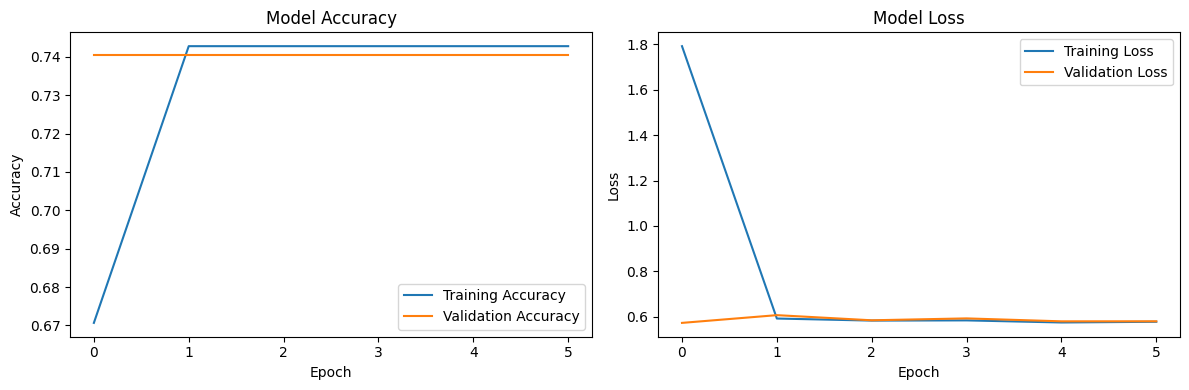

: 

In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import os
from PIL import Image

def patch_images(images, patch_size):
    batch_size = tf.shape(images)[0]
    patches = tf.image.extract_patches(
        images=images,
        sizes=[1, patch_size, patch_size, 1],
        strides=[1, patch_size, patch_size, 1],
        rates=[1, 1, 1, 1],
        padding="VALID",
    )
    patch_dims = patches.shape[-1]
    patches = tf.reshape(patches, [batch_size, -1, patch_dims])
    return patches

def create_vit_model(input_shape=(224, 224, 3), patch_size=16, num_classes=1, d_model=768, num_heads=12, num_layers=12, mlp_dim=3072, dropout=0.1):
    inputs = layers.Input(shape=input_shape)
    patches = layers.Lambda(lambda x: patch_images(x, patch_size))(inputs)
    num_patches = (input_shape[0] // patch_size) * (input_shape[1] // patch_size)
    patch_embed = layers.Dense(d_model)(patches)
    positions = tf.range(start=0, limit=num_patches, delta=1)
    pos_embed = layers.Embedding(input_dim=num_patches, output_dim=d_model)(positions)
    x = patch_embed + pos_embed

    for _ in range(num_layers):
        x1 = layers.LayerNormalization(epsilon=1e-6)(x)
        attention_output = layers.MultiHeadAttention(num_heads=num_heads, key_dim=d_model // num_heads)(x1, x1)
        x2 = layers.Add()([attention_output, x])
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        x3 = layers.Dense(mlp_dim, activation="gelu")(x3)
        x3 = layers.Dense(d_model)(x3)
        x3 = layers.Dropout(dropout)(x3)
        x = layers.Add()([x3, x2])

    x = layers.LayerNormalization(epsilon=1e-6)(x)
    x = layers.GlobalAveragePooling1D()(x)
    outputs = layers.Dense(num_classes, activation="sigmoid")(x)
    return models.Model(inputs=inputs, outputs=outputs)

def load_and_preprocess_image(image_path, target_size=(224, 224)):
    img = Image.open(image_path).resize(target_size)
    img_array = np.array(img) / 255.0  # Normalize to [0, 1]
    return img_array

if __name__ == "__main__":
    # Set up paths
    dataset_dir = "/home/kirtimaan/Projects/archive/ORIGA/ORIGA/Images"
    csv_file = "/home/kirtimaan/Projects/archive/glaucoma.csv"

    # Load CSV data
    df = pd.read_csv(csv_file)
    image_paths = [os.path.join(dataset_dir, filename) for filename in df['Filename']]
    labels = df['Glaucoma'].values

    # Load all images
    target_size = (224, 224)
    images = np.array([load_and_preprocess_image(path, target_size) for path in image_paths])
    labels = np.array(labels)

    # Split the dataset
    X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42, stratify=labels)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)

    # Create TensorFlow datasets
    train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(16).prefetch(tf.data.AUTOTUNE)
    val_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(16).prefetch(tf.data.AUTOTUNE)
    test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(16).prefetch(tf.data.AUTOTUNE)

    # Create and compile the model
    vit_model = create_vit_model(input_shape=(*target_size, 3))
    vit_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    # Train the model
    history = vit_model.fit(
        train_ds,
        epochs=20,
        validation_data=val_ds,
        callbacks=[
            tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True),
            tf.keras.callbacks.ReduceLROnPlateau(factor=0.2, patience=3)
        ]
    )

    # Evaluate the model on the test set
    test_loss, test_accuracy = vit_model.evaluate(test_ds)
    print(f"Test accuracy: {test_accuracy:.4f}")

    # Generate predictions on the test set
    y_pred = vit_model.predict(test_ds)
    y_pred_classes = (y_pred > 0.5).astype(int)

    # Print classification report and confusion matrix
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred_classes))
    print("\nConfusion Matrix:")
    print(confusion_matrix(y_test, y_pred_classes))

    # Plot training history
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [2]:
import tensorflow as tf
from tensorflow.keras import layers, models
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import os
from PIL import Image

# Ensure that TensorFlow uses the GPU if available
physical_devices = tf.config.list_physical_devices('GPU')
if len(physical_devices) > 0:
    try:
        for device in physical_devices:
            tf.config.experimental.set_memory_growth(device, True)
        print(f"TensorFlow is using GPU: {physical_devices}")
    except RuntimeError as e:
        print(e)
else:
    print("No GPU detected, running on CPU.")

def patch_images(images, patch_size):
    batch_size = tf.shape(images)[0]
    patches = tf.image.extract_patches(
        images=images,
        sizes=[1, patch_size, patch_size, 1],
        strides=[1, patch_size, patch_size, 1],
        rates=[1, 1, 1, 1],
        padding="VALID",
    )
    patch_dims = patches.shape[-1]
    patches = tf.reshape(patches, [batch_size, -1, patch_dims])
    return patches

def create_vit_model(input_shape=(224, 224, 3), patch_size=16, num_classes=1, d_model=768, num_heads=12, num_layers=12, mlp_dim=3072, dropout=0.1):
    inputs = layers.Input(shape=input_shape)
    patches = layers.Lambda(lambda x: patch_images(x, patch_size))(inputs)
    num_patches = (input_shape[0] // patch_size) * (input_shape[1] // patch_size)
    patch_embed = layers.Dense(d_model)(patches)
    positions = tf.range(start=0, limit=num_patches, delta=1)
    pos_embed = layers.Embedding(input_dim=num_patches, output_dim=d_model)(positions)
    x = patch_embed + pos_embed

    for _ in range(num_layers):
        x1 = layers.LayerNormalization(epsilon=1e-6)(x)
        attention_output = layers.MultiHeadAttention(num_heads=num_heads, key_dim=d_model // num_heads)(x1, x1)
        x2 = layers.Add()([attention_output, x])
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        x3 = layers.Dense(mlp_dim, activation="gelu")(x3)
        x3 = layers.Dense(d_model)(x3)
        x3 = layers.Dropout(dropout)(x3)
        x = layers.Add()([x3, x2])

    x = layers.LayerNormalization(epsilon=1e-6)(x)
    x = layers.GlobalAveragePooling1D()(x)
    outputs = layers.Dense(num_classes, activation="sigmoid")(x)
    return models.Model(inputs=inputs, outputs=outputs)

def load_and_preprocess_image(image_path, target_size=(224, 224)):
    img = Image.open(image_path).resize(target_size)
    img_array = np.array(img) / 255.0  # Normalize to [0, 1]
    return img_array

if __name__ == "__main__":
    # Set up paths
    dataset_dir = "/home/kirtimaan/Projects/archive/ORIGA/ORIGA/Images"
    csv_file = "/home/kirtimaan/Projects/archive/glaucoma.csv"

    # Load CSV data
    df = pd.read_csv(csv_file)
    image_paths = [os.path.join(dataset_dir, filename) for filename in df['Filename']]
    labels = df['Glaucoma'].values

    # Load all images
    target_size = (224, 224)
    images = np.array([load_and_preprocess_image(path, target_size) for path in image_paths])
    labels = np.array(labels)

    # Split the dataset
    X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42, stratify=labels)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)

    # Create TensorFlow datasets
    train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(16).prefetch(tf.data.AUTOTUNE)
    val_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(16).prefetch(tf.data.AUTOTUNE)
    test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(16).prefetch(tf.data.AUTOTUNE)

    # Create and compile the model
    vit_model = create_vit_model(input_shape=(*target_size, 3))
    vit_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    # Train the model
    history = vit_model.fit(
        train_ds,
        epochs=100,
        validation_data=val_ds,
        callbacks=[
            tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True),
            tf.keras.callbacks.ReduceLROnPlateau(factor=0.2, patience=3)
        ]
    )

    # Evaluate the model on the test set
    test_loss, test_accuracy = vit_model.evaluate(test_ds)
    print(f"Test accuracy: {test_accuracy:.4f}")

    # Generate predictions on the test set
    y_pred = vit_model.predict(test_ds)
    y_pred_classes = (y_pred > 0.5).astype(int)

    # Print classification report and confusion matrix
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred_classes))
    print("\nConfusion Matrix:")
    print(confusion_matrix(y_test, y_pred_classes))

    # Plot training history
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()


No GPU detected, running on CPU.
Epoch 1/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 131s 5s/step - accuracy: 0.6810 - loss: 3.1302 - val_accuracy: 0.7404 - val_loss: 0.6356 - learning_rate: 0.0010
Epoch 2/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 119s 5s/step - accuracy: 0.7419 - loss: 0.6150 - val_accuracy: 0.7404 - val_loss: 0.5812 - learning_rate: 0.0010
Epoch 3/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 117s 5s/step - accuracy: 0.7419 - loss: 0.5900 - val_accuracy: 0.7404 - val_loss: 0.5935 - learning_rate: 0.0010
Epoch 4/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 117s 5s/step - accuracy: 0.7419 - loss: 0.5998 - val_accuracy: 0.7404 - val_loss: 0.6005 - learning_rate: 0.0010
Epoch 5/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 117s 5s/step - accuracy: 0.7419 - loss: 0.6033 - val_accuracy: 0.7404 - val_loss: 0.6028 - learning_rate: 0.0010
Epoch 6/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 128s 5s/step - accuracy: 0.7419 - loss: 0.5880 - val_accuracy: 0.7404 - val_loss: 0.5797 - learning_rate: 2.0000e-04
Epoch 7/100


In [4]:
!pip list | grep tensorflow


fish: Unknown command: nvcc
fish: 
nvcc --version
^


In [18]:
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
for device in gpu_devices:
    tf.config.experimental.set_memory_growth(device, True)